# INSTALL PACKAGES
cv2 - https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API

## DEPENDECIES

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import sklearn
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Helper libraries
import numpy as np
import math
import matplotlib.pyplot as plt
import glob
import shutil
import os
import cv2

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## IMPORT DATA

In [4]:
_URL = "https://mattharmer.me/fish_filtered_8.zip"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="fish_filtered_8.zip",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'fish_filtered_8')

classes = ['amphiprionclarkii',
           'chaetodonlunulatus',
           'chromischrysura',
           'coryphaenahippurus',
           'dascyllusreticulatus',
           'myripristiskuntee',
           'neoniphonsammara',
           'plectroglyphidodondickii'
          ]

In [5]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

amphiprionclarkii: 200 Images


Error: Destination path 'C:\Users\Matt\.keras\datasets\fish_filtered_8\train\amphiprionclarkii\1001.jpg' already exists

In [6]:
round(len(images)*0.8)

160

In [52]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [8]:
batch_size = 32
IMG_SHAPE = 224

In [55]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

val_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                directory=val_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse')

Found 1280 images belonging to 8 classes.
Found 320 images belonging to 8 classes.


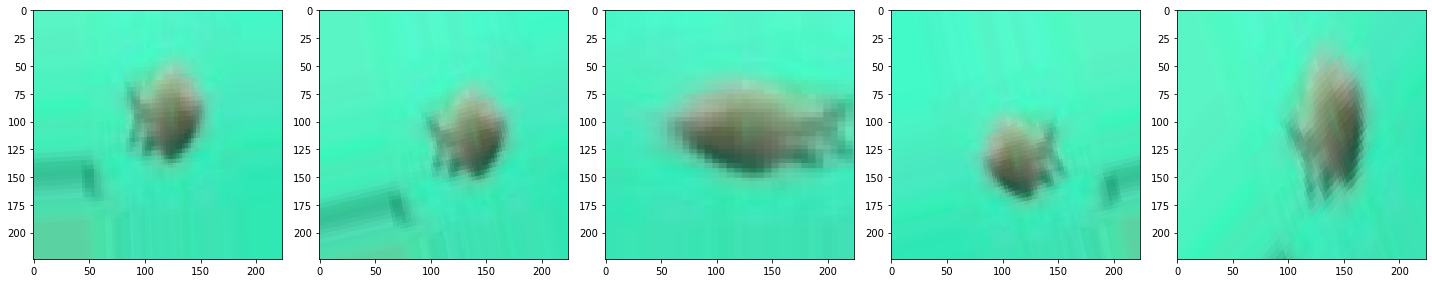

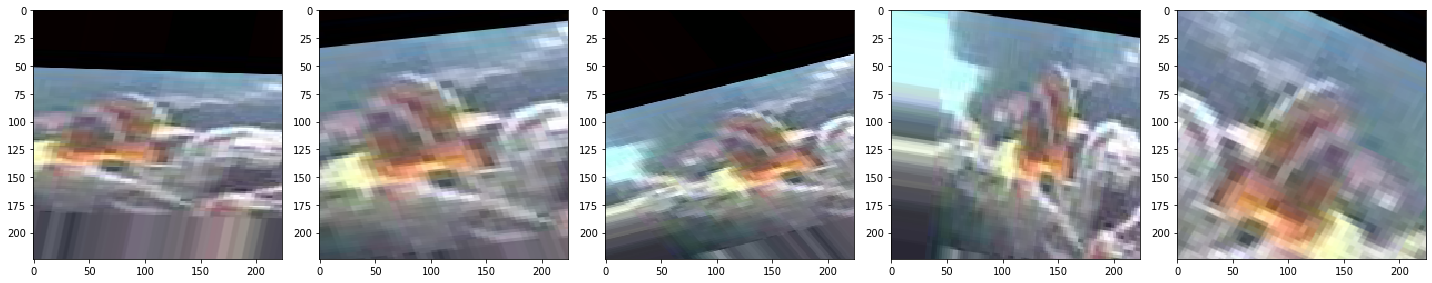

In [56]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

augmented_images = [val_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [31]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

In [12]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [13]:
feature_extractor.trainable = False

In [14]:
model = Sequential(feature_extractor)
model.add(Dense(8))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 8)                 10248     
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
epochs = 100

history = model.fit(train_data_gen,
                    epochs=epochs,
                    validation_data=val_data_gen)

Train for 40 steps, validate for 10 steps
Epoch 1/100
40/40 [==============================] - 67s 2s/step - loss: 1.1225 - accuracy: 0.6250 - val_loss: 0.8425 - val_accuracy: 0.7000
Epoch 2/100
40/40 [==============================] - 50s 1s/step - loss: 0.4388 - accuracy: 0.8875 - val_loss: 0.6488 - val_accuracy: 0.7750
Epoch 3/100
40/40 [==============================] - 49s 1s/step - loss: 0.3128 - accuracy: 0.9117 - val_loss: 0.5885 - val_accuracy: 0.7844
Epoch 4/100
40/40 [==============================] - 49s 1s/step - loss: 0.2383 - accuracy: 0.9320 - val_loss: 0.5545 - val_accuracy: 0.8031
Epoch 5/100
40/40 [==============================] - 50s 1s/step - loss: 0.2171 - accuracy: 0.9383 - val_loss: 0.4680 - val_accuracy: 0.8281
Epoch 6/100
40/40 [==============================] - 49s 1s/step - loss: 0.1814 - accuracy: 0.9547 - val_loss: 0.4675 - val_accuracy: 0.8438
Epoch 7/100
40/40 [==============================] - 50s 1s/step - loss: 0.1725 - accuracy: 0.9469 - val_loss: 0

40/40 [==============================] - 49s 1s/step - loss: 0.0556 - accuracy: 0.9781 - val_loss: 0.4007 - val_accuracy: 0.8969
Epoch 59/100
40/40 [==============================] - 49s 1s/step - loss: 0.0375 - accuracy: 0.9922 - val_loss: 0.5091 - val_accuracy: 0.8687
Epoch 60/100
40/40 [==============================] - 50s 1s/step - loss: 0.0438 - accuracy: 0.9875 - val_loss: 0.4347 - val_accuracy: 0.8844
Epoch 61/100
40/40 [==============================] - 49s 1s/step - loss: 0.0537 - accuracy: 0.9812 - val_loss: 0.3822 - val_accuracy: 0.8875
Epoch 62/100
40/40 [==============================] - 49s 1s/step - loss: 0.0419 - accuracy: 0.9867 - val_loss: 0.5419 - val_accuracy: 0.9062
Epoch 63/100
40/40 [==============================] - 49s 1s/step - loss: 0.0574 - accuracy: 0.9828 - val_loss: 0.4598 - val_accuracy: 0.8687
Epoch 64/100
40/40 [==============================] - 49s 1s/step - loss: 0.0454 - accuracy: 0.9891 - val_loss: 0.4672 - val_accuracy: 0.8781
Epoch 65/100
40/40 

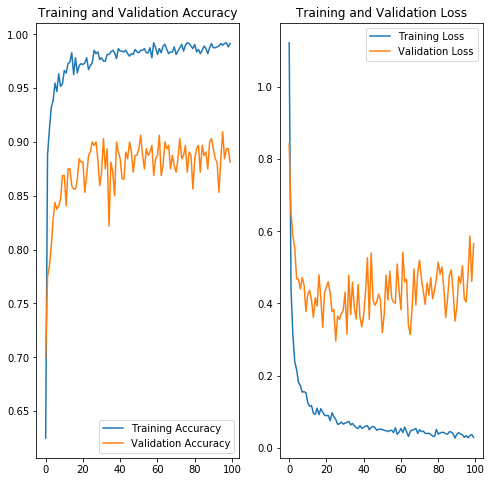

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()